In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os                        
import pandas as pd
import numpy as np
import math 
import statistics
from sklearn.model_selection import train_test_split
from sklearn import metrics


In [2]:
def load_dataset(file_name, category_col_name):#takes dataset's file name and the label name. returns vectors df, label series and label mapping.
    df = pd.read_csv(file_name)
    df[category_col_name], category_map = pd.factorize(df[category_col_name])
    
    return df.drop(columns=category_col_name), df[category_col_name], pd.Series(category_map)

In [3]:
def calc_class_priors(y_train, lst_class_vals):
    class_priors = []
    for cls in lst_class_vals:
        class_priors.append(y_train.value_counts().iloc[cls]/len(y_train))
    return class_priors

In [4]:
def calc_mean_for_likelihood(training_set, category_col_name):
    class_lst=training_set[category_col_name].unique()
    class_lst=np.sort(class_lst)
    mean_dict={};

    for feat in training_set.drop(columns=category_col_name): 
        mean_dict[feat]=[]
        for cls in class_lst:
            mean_dict[feat].append(training_set[(training_set[category_col_name]==cls)][feat].mean())
    df=pd.DataFrame(mean_dict,index=class_lst)
    return df

In [5]:
def calc_std_for_likelihood(training_set, category_col_name):
    std_dict={}
    class_lst=training_set[category_col_name].unique()
    class_lst=np.sort(class_lst)
    for feat in training_set.drop(columns=category_col_name):
        std_dict[feat]=[]
        for cls in class_lst:
            std_dict[feat].append(training_set[(training_set[category_col_name])==cls][feat].std())
    df=pd.DataFrame(std_dict, index=class_lst)
    return df

In [6]:
def fit(training_set,category_col_name):
    class_list=np.sort(training_set[category_col_name].unique()) #sorting class label to use as an indices
    #discrete feature
    
    #continuous feat
    lst_class_priors = calc_class_priors(training_set[category_col_name],class_list)#claculation priors
    df_mean_likelihood=calc_mean_for_likelihood(training_set, category_col_name)#claculation mean
    df_std_likelihood=calc_std_for_likelihood(training_set, category_col_name)#claculation std
    return lst_class_priors, df_mean_likelihood, df_std_likelihood

In [7]:
def calc_gaussian_pdf_prob(x_feature_val, feature_mean, feature_std):
    exponent = np.exp(-((x_feature_val-feature_mean)**2 / (2 * feature_std**2 )))
    return (1 / ((2 * np.pi)**(1/2) * feature_std)) * exponent

In [8]:
def calc_aposterior_probs(X_test, lst_class_priors, df_trained_mean, df_trained_std, lst_class_vals):
    num_classes = len(lst_class_vals)
    df_prob_per_test_inst_per_class = pd.DataFrame(np.zeros((X_test.shape[0], num_classes)), columns=lst_class_vals, index=X_test.index)

    for cls, prior in enumerate(lst_class_priors): #for each class #cls represents the lst_class_priors index and the actual class number
        for row_index, vector in X_test.iterrows():#extacting feature vector from the test set
            df_prob_per_test_inst_per_class.iloc[row_index,cls]=np.log(prior)
            #print("row %d, col %d" %(row_index, cls)) #DBGIN
            for feat, x_val in vector.items(): #for each feature vector, x value
                mean = df_trained_mean.loc[cls,feat]
                std = df_trained_std.loc[cls,feat]
                #print("cls %d, feature %s" %(cls, feat)) #DBGIN
                
                
                feat_prob = calc_gaussian_pdf_prob(x_val, mean, std) #calculate the conditional prob of x value
                
                df_prob_per_test_inst_per_class.iloc[row_index, cls]+=np.log(feat_prob) #prior and conditional probs product
            
           
    return df_prob_per_test_inst_per_class

In [9]:
def predict(X_test, lst_class_priors, df_trained_mean, df_trained_std, lst_class_vals):
    
    y=pd.Series(0, index=range(X_test.shape[0])) #creating empty prediction series
    df=calc_aposterior_probs(X_test, lst_class_priors, df_trained_mean, df_trained_std, lst_class_vals)
    
    for vector_index, probs_per_cls in df.iterrows():
        y.iloc[vector_index]=np.argmax(probs_per_cls)
    return y

In [10]:
def set_numbered_index(df, series):
    df=df.set_index(np.arange(df.shape[0]))
    series.index=np.arange(len(series))
    return df, series

In [11]:
file_name = str(os.getcwd())+str(os.sep)+'Iris.csv'
label_col='species'
X, y, label_mapping=load_dataset(file_name, label_col)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)
X_train, y_train=set_numbered_index(X_train, y_train)
X_test, y_test=set_numbered_index(X_test, y_test)

#X_test=set_numbered_index(X_test)
#y_test=set_numbered_index(y_test)
train_set=X_train.copy(deep=True)
train_set[label_col]=y_train
train_set.head(5)
#y_train.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.0,3.4,1.5,0.2,0
1,6.9,3.1,4.9,1.5,1
2,6.2,2.8,4.8,1.8,2
3,5.6,2.9,3.6,1.3,1
4,6.9,3.2,5.7,2.3,2


In [12]:
label_mapping.index.to_list()


[0, 1, 2]

In [13]:
lst_priors, df_mean, df_std=fit(train_set,label_col)

In [14]:
lst_priors
df_mean
df_std

,sepal_length,sepal_width,petal_length,petal_width
0,0.233095,0.346410,0.141814,0.066667
1,0.518130,0.314222,0.536678,0.208609
2,0.588861,0.322737,0.539269,0.281646


In [15]:
y_predicted=predict(X_test, lst_priors, df_mean, df_std, label_mapping.index.to_list())


In [16]:
def evaluation(y_test, y_pred):
    cm=metrics.confusion_matrix(y_test, y_pred)
    acc=metrics.accuracy_score(y_test, y_pred)
    
    er=1-acc
    return cm, acc, er

In [17]:
cm, acc, er = evaluation(y_predicted, y_test)
print("accuracy: %.2f, error rate: %.2f" %(acc, er))

accuracy: 0.93, error rate: 0.07


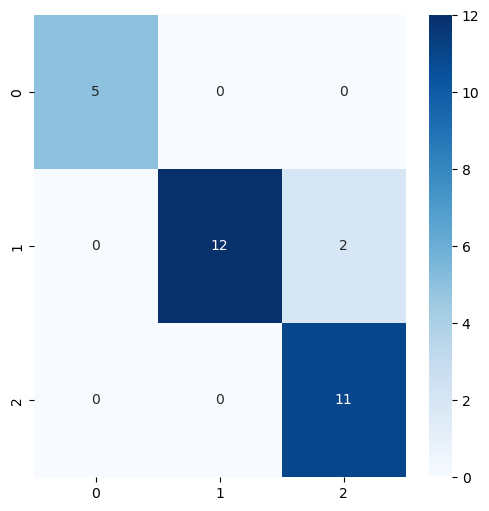

In [18]:
plt.figure(figsize=(6,6))
sns.heatmap(cm,annot=True, cmap='Blues', fmt='d')
plt.xlabel='Actual'
plt.ylabel='predicted'
plt.title='Model evaluation'
plt.show()